In [10]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 원-핫 인코딩
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


170498071/170498071 [==============================] - 5s 0us/step


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
1563/1563 [==============================] - 76s 48ms/step - loss: 1.6146 - accuracy: 0.4235 - val_loss: 1.2636 - val_accuracy: 0.5451
Epoch 2/10
1563/1563 [==============================] - 71s 45ms/step - loss: 1.2393 - accuracy: 0.5585 - val_loss: 1.0728 - val_accuracy: 0.6190
Epoch 3/10
1563/1563 [==============================] - 69s 44ms/step - loss: 1.1017 - accuracy: 0.6127 - val_loss: 0.9901 - val_accuracy: 0.6569
Epoch 4/10
1563/1563 [==============================] - 68s 44ms/step - loss: 1.0127 - accuracy: 0.6453 - val_loss: 0.9296 - val_accuracy: 0.6746
Epoch 5/10
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9382 - accuracy: 0.6690 - val_loss: 0.8846 - val_accuracy: 0.6954
Epoch 6/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.8774 - accuracy: 0.6909 - val_loss: 0.8658 - val_accuracy: 0.6970
Epoch 7/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.8257 - accuracy: 0.7096 - val_loss: 0.8756 -

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.show()

In [13]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 100) (10000, 32, 32, 3) (10000, 100)


In [14]:
import cv2
import numpy as np

def apply_transformations(image, transformation_type):
    # Check the input image is not None and has valid dimensions
    if image is None or image.size == 0 or image.shape[0] <= 0 or image.shape[1] <= 0:
        raise ValueError("Invalid input image shape")

    # Validate the data type of the image and normalize if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    # Apply the specified transformation
    if transformation_type == 'noise':
        noise = np.random.normal(0, 0.1, image.shape)
        transformed_image = np.clip(image + noise, 0, 1)

    elif transformation_type == 'blur':
      blurred_images = np.zeros_like(image)
      for i in range(image.shape[0]):
        blurred_images[i] = cv2.GaussianBlur(image[i], (5,5), 0)
      transformed_image = blurred_images  # Apply Gaussian blur with a 5x5 kernel


    elif transformation_type == 'brightness':
      # Ensure the image is in np.float32 format and in the range [0,1]
      if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

      factor = np.random.uniform(0.9, 1.1)  # Random brightness factor
      transformed_image = np.clip(image * factor, 0, 1)  # Adjust brightness and clip


    else:
        raise ValueError(f"Unknown transformation type: {transformation_type}")

    # If necessary, convert transformed image back to uint8
    if image.dtype == np.float32:
        transformed_image = (transformed_image * 255).astype(np.uint8)

    return transformed_image



In [15]:
# 예측 함수 예제
def automated_attack(model, x_test, y_test, iterations=3):
    correct_predictions = 0
    total_predictions = 0

    for i in range(iterations):
        original_image = x_test[i:i+1]
        true_label = np.argmax(y_test[i])

        transformation_type = np.random.choice(['noise', 'blur', 'brightness'])
        transformed_image = apply_transformations(original_image, transformation_type)

        print("transformation_type, {}".format(transformation_type))
        print("transformed_image_shape, {}".format(transformed_image.shape))

        if len(transformed_image.shape) == 2:  # If grayscale, model expects color channels
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_GRAY2RGB)

        if transformed_image.shape == (32, 32, 3):
            transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2GRAY)

        # Reshape for model prediction
        transformed_image = transformed_image.reshape(32, 32, 3)

        # Reshape for model prediction
        prediction = model.predict(transformed_image.reshape(1, 32, 32, 3))
        predicted_label = np.argmax(prediction)

        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

        print(f"Iteration {i + 1}:")
        print(f"Predicted label: {predicted_label} (True label: {true_label})")
        print(f"Accuracy so far: {correct_predictions / total_predictions:.2f}")


        display_image(transformed_image)


        # Update original_image for next iteration; ensure it is correctly reshaped
        original_image = transformed_image.reshape(32, 32, 3)

        print(f"Final accuracy: {correct_predictions / total_predictions:.2f}")

        #image_index = (image_index + 1) % len(x_test)  # Cycle through test set

transformation_type, noise
transformed_image_shape, (1, 32, 32, 3)
1/1 [==============================] - 0s 191ms/step
Iteration 1:
Predicted label: 9 (True label: 3)
Accuracy so far: 0.00


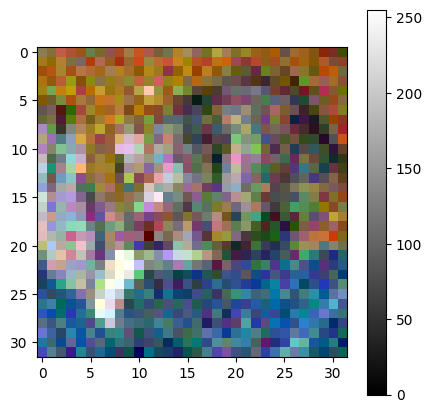

Final accuracy: 0.00
transformation_type, noise
transformed_image_shape, (1, 32, 32, 3)
1/1 [==============================] - 0s 47ms/step
Iteration 2:
Predicted label: 9 (True label: 8)
Accuracy so far: 0.00


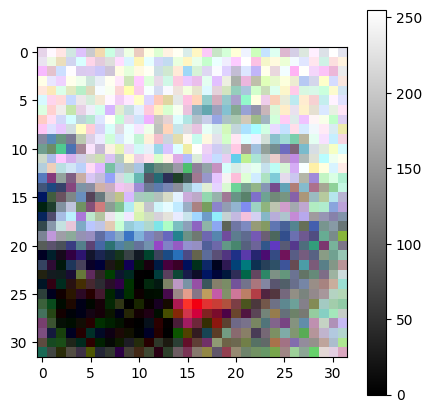

Final accuracy: 0.00
transformation_type, brightness
transformed_image_shape, (1, 32, 32, 3)
1/1 [==============================] - 0s 32ms/step
Iteration 3:
Predicted label: 8 (True label: 8)
Accuracy so far: 0.33


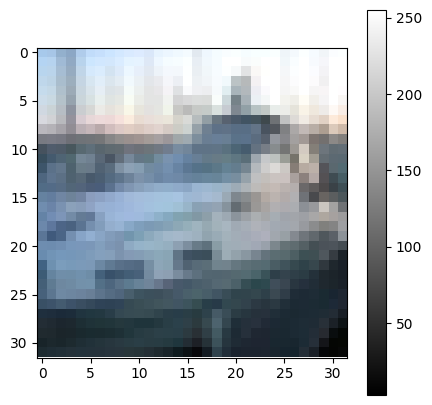

Final accuracy: 0.33


In [16]:
automated_attack(model, x_test, y_test)